# Data
Download the IMDB reviews if its not already in the local cache.
Load from the local cache and split to train and test sets.

In [1]:
import os
import ssl
from keras.utils import get_file
try:
    from notebooks.data import load_imdb
except ModuleNotFoundError:
    from data import load_imdb

if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)): 
    ssl._create_default_https_context = ssl._create_unverified_context
    
zip_file = get_file('aclImdb.zip', origin='http://mng.bz/0tIo', extract=True)
imdb_dir = zip_file.replace('.zip', '')
(train_texts, train_labels), (test_texts, test_labels) = load_imdb(imdb_dir)

print('An example from the reviews:')
print('============================')
print(f'Text : {train_texts[0][:200]}...')
print(f'Label: {train_labels[0]}')

Using TensorFlow backend.


An example from the reviews:
Text : If you are expecting to see a lot in the bath of Alt&#305;oklar, as it is promised by the tag line, you will be very disappointed to see that the movie consists of nothing but the populist style of Al...
Label: neg


# Prepare Data
Initialize a `SentWordVectorizer`. The vectorizer will be fitted on the 
`train_texts`. We will use a simple sentence tokenizer and no word tokenizer, 
so the words will be split on spaces. The vocabulary is restricted to 
`num_words` words.

In [2]:
from keras_nlp.preprocessing import sent_tokenize
from keras_nlp import SentWordVectorizer

num_words = 50000
sent_word_vectorizer = SentWordVectorizer(
    sent_tokenize, num_words=num_words, oov_token='UNK')
sent_word_vectorizer.fit_on_texts(train_texts)
# The vectorizer's number of tokens num_words + PAD + OOV token
print(f'Vectorizer number of tokens: {sent_word_vectorizer.num_tokens}')

19-Dec-06 23:35:37 [INFO    ] [SentWordVectorizer] - Creating vocabulary.


25000/25000 [==============================] - 2s 71us/step
Vectorizer number of tokens: 50002


## Vectorize Data
We apply the fitted vectorizer to the train and test texts. 
Also we have to set the `max_sentences` per text and `max_tokens` per sentence. 

In [3]:
max_sentences, max_tokens = 10, 15
X_train = sent_word_vectorizer.texts_to_vectors(
    train_texts, shape=(max_sentences, max_tokens))

19-Dec-06 23:35:39 [INFO    ] [SentWordVectorizer] - Converting texts to vectors.
19-Dec-06 23:35:45 [INFO    ] [SentWordVectorizer] - Reshaping vectors to shape (10, 15).


25000/25000 [==============================] - 2s 65us/step


**Attention**: We *must* pass the same number of `max_sentences` and 
`max_tokens` when converting different text sets. If we don't, then it is 
almost certain that the results will have different numbers of columns because 
the set are likely to have different number of tokens.

In [4]:
X_test = sent_word_vectorizer.texts_to_vectors(
    test_texts, shape=(max_sentences, max_tokens))

19-Dec-06 23:35:47 [INFO    ] [SentWordVectorizer] - Converting texts to vectors.
19-Dec-06 23:35:54 [INFO    ] [SentWordVectorizer] - Reshaping vectors to shape (10, 15).


25000/25000 [==============================] - 2s 63us/step


# Decode Data
Print a decoded fragment of an encoded text as an example.

In [5]:
decoded = sent_word_vectorizer.vectors_to_texts(X_test[:1])
print(decoded[0][2])

19-Dec-06 23:35:56 [INFO    ] [SentWordVectorizer] - Converting vectors to texts.


10/10 [==============================] - 0s 60us/step
['what', 'a', 'nice', 'and', 'kind', 'man']


## Encode Labels
The labels are strings ('pos' / 'neg'). We will convert them to numbers.

In [6]:
from sklearn.preprocessing import label_binarize

y_train = label_binarize(train_labels, classes=['neg', 'pos'])
y_test = label_binarize(test_labels, classes=['neg', 'pos'])

## Keep a Validation Set

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, stratify=y_train, shuffle=True, random_state=44)

print(f'X_train: {X_train.shape}')
print(f'X_dev  : {X_val.shape}')
print(f'X_test : {X_test.shape}')

X_train: (18750, 10, 15)
X_dev  : (6250, 10, 15)
X_test : (25000, 10, 15)


# Neural Network
Here we define a toy network for demonstration purpose.
The model has two layers. The first encodes the words of a sentence providing 
sentence vectors. The second encodes the sentence
vectors to a document vector.

## Word Encoder Model
You might want to use an Attention layer instead of a Flatten in both 
`word_model` and `model`.

In [8]:
from keras.models import Model
from keras.layers import (Input, Embedding, Flatten, Dense, Bidirectional,
                          LSTM, TimeDistributed, Dropout)

rnn_params = dict(dropout=0.2, return_sequences=True, recurrent_dropout=0.2)

words_input = Input(shape=(max_tokens, ), name='Words_Input', dtype='int32')
words_embeddings = Embedding(
    input_dim=sent_word_vectorizer.num_tokens,
    output_dim=100,
    input_length=max_tokens,
    mask_zero=False,
    trainable=True,
    name='Embeddings')(words_input)
words_encoder = Bidirectional(
    LSTM(100, **rnn_params), name='Words_Encoder')(words_embeddings)
x = Flatten(name='Flatten')(words_encoder)
word_model = Model(words_input, x)

print(word_model.summary(line_length=90))

__________________________________________________________________________________________
Layer (type)                            Output Shape                        Param #       
Words_Input (InputLayer)                (None, 15)                          0             
__________________________________________________________________________________________
Embeddings (Embedding)                  (None, 15, 100)                     5000200       
__________________________________________________________________________________________
Words_Encoder (Bidirectional)           (None, 15, 200)                     160800        
__________________________________________________________________________________________
Flatten (Flatten)                       (None, 3000)                        0             
Total params: 5,161,000
Trainable params: 5,161,000
Non-trainable params: 0
__________________________________________________________________________________________
None


## Sentence Encoder Model

In [9]:
sent_input = Input(
    shape=(max_sentences, max_tokens), dtype='int32', name='Sent_Input')
sent_input_over_word_model = TimeDistributed(
    word_model, name='Word_Model')(sent_input)
sent_encoder = Bidirectional(
    LSTM(100, **rnn_params), name='Sents_Encoder')(sent_input_over_word_model)
x = Dropout(0.3, name='Dropout')(sent_encoder)
x = Flatten(name='Flatten')(x)
predictions = Dense(1, activation='sigmoid', name='Predictions')(x)
model = Model(sent_input, predictions)

print(model.summary(line_length=90))

__________________________________________________________________________________________
Layer (type)                            Output Shape                        Param #       
Sent_Input (InputLayer)                 (None, 10, 15)                      0             
__________________________________________________________________________________________
Word_Model (TimeDistributed)            (None, 10, 3000)                    5161000       
__________________________________________________________________________________________
Sents_Encoder (Bidirectional)           (None, 10, 200)                     2480800       
__________________________________________________________________________________________
Dropout (Dropout)                       (None, 10, 200)                     0             
__________________________________________________________________________________________
Flatten (Flatten)                       (None, 2000)                        0             

## Train Model

In [10]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(X_train,
                    y_train, 
                    batch_size=50, 
                    epochs=5, 
                    validation_data=(X_val, y_val))

Train on 18750 samples, validate on 6250 samples
Epoch 1/5
18750/18750 [==============================] - 43s 2ms/step - loss: 0.4362 - acc: 0.7878 - val_loss: 0.3124 - val_acc: 0.8664

## Model Evaluation

In [11]:
scores = model.evaluate(X_test, y_test)
print(f'Evaluation accuracy: {100*scores[1]:.2f}%')

25000/25000 [==============================] - 26s 1ms/step

# Plot Accuracy and Loss

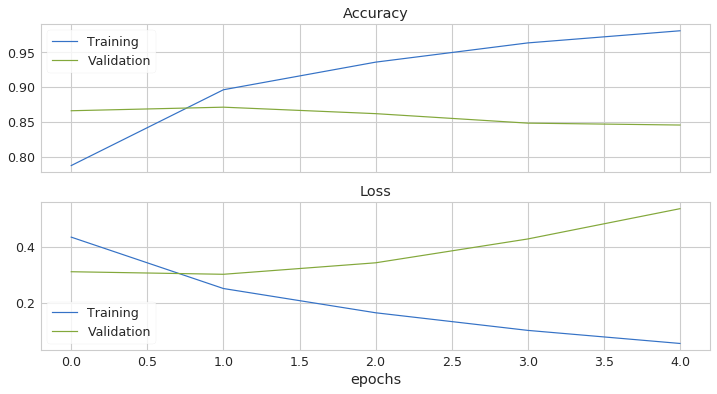

In [12]:
from matplotlib import pyplot as plt
%matplotlib inline

_, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 6))
ax1.plot(history.epoch, history.history['acc'], label='Training')
ax1.plot(history.epoch, history.history['val_acc'], label='Validation')
ax1.set_title('Accuracy')
ax1.legend()

ax2.plot(history.epoch, history.history['loss'], label='Training')
ax2.plot(history.epoch, history.history['val_loss'], label='Validation')
ax2.set_title('Loss')
ax2.set_xlabel('epochs')
ax2.legend()

plt.show()